In [7]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import imageio
from IPython.display import Video

from src.encoder import VICRegJEPAEncoder
from src.data.dataset import PointMazeVICReg

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


Load the dataset

In [8]:
dataset = PointMazeVICReg(
    "data/train_trajectories_10_100_4_64.npz",
    frame_size=(64, 64),
    mask_ratio=0.1,
    patch_size=8
)

[VICRegDataset] Loaded 1010 images.


Load the model

In [9]:
visual_encoder = VICRegJEPAEncoder.load_from_checkpoint("checkpoints/visual_encoder/last.ckpt", strict=False)
visual_encoder.to(device)
visual_encoder.eval();

In [10]:
save_nets = False
if save_nets:
    base_path = "checkpoints/pth/"
    torch.save(visual_encoder.visual_encoder.state_dict(), base_path + "visual_encoder.pth")
    torch.save(visual_encoder.proprio_encoder.state_dict(), base_path + "proprio_encoder.pth")
    torch.save(visual_encoder.visual_decoder.state_dict(), base_path + "visual_decoder.pth")
    torch.save(visual_encoder.proprio_decoder.state_dict(), base_path + "proprio_decoder.pth")

Define helpful methods

In [11]:
def show_reconstruction(idx):
    (img, img_aug), _, _ = dataset[idx]   # dataset returns ((img, img_aug), obs)
    img = img.unsqueeze(0).to(device)    # (1, 3, 64, 64)

    with torch.no_grad():
        with torch.amp.autocast("cuda", dtype=torch.bfloat16):
            cls, patches, _ = visual_encoder.visual_encoder(img)
            recon = visual_encoder.visual_decoder(patches).float()
            cls = cls.float()
            patches = patches.float()

    fig, ax = plt.subplots(1, 3, figsize=(10, 4))
    ax[0].imshow(img[0].permute(1,2,0).cpu())
    ax[0].set_title("Original"); ax[0].axis("off")

    ax[1].imshow(img_aug.permute(1,2,0))
    ax[1].set_title("Augmented (mask+jitter)"); ax[1].axis("off")

    ax[2].imshow(recon[0].permute(1,2,0).cpu())
    ax[2].set_title("Reconstruction (decoder probe)"); ax[2].axis("off")

    plt.show()


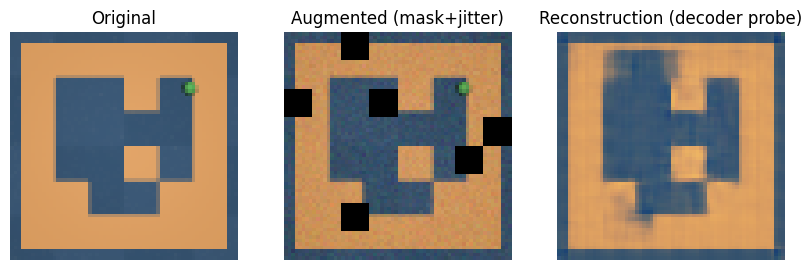

In [12]:
show_reconstruction(42)

In [18]:
def scatter_trajectory(traj_indices):
    cls_tokens = []
    positions  = []

    for idx in traj_indices:
        (img,_), obs, _ = dataset[idx]
        img = img.unsqueeze(0).to(device)

        with torch.no_grad():
            with torch.amp.autocast("cuda", dtype=torch.bfloat16):
                cls, patches, _ = visual_encoder.visual_encoder(img)
                cls = cls.float()
                patches = patches.float()

        cls_tokens.append(cls.squeeze().cpu().numpy())
        positions.append(obs[:2])

    cls_tokens = np.array(cls_tokens)
    positions  = np.array(positions)

    plt.figure(figsize=(6,6))
    plt.scatter(cls_tokens[:,0], cls_tokens[:,1], c=np.linspace(0,1,len(cls_tokens)))
    plt.title("CLS latent trajectory")
    plt.show()

    plt.figure(figsize=(6,6))
    plt.scatter(positions[:,0], positions[:,1], c=np.linspace(0,1,len(cls_tokens)))
    plt.title("True XY movement")
    plt.show()

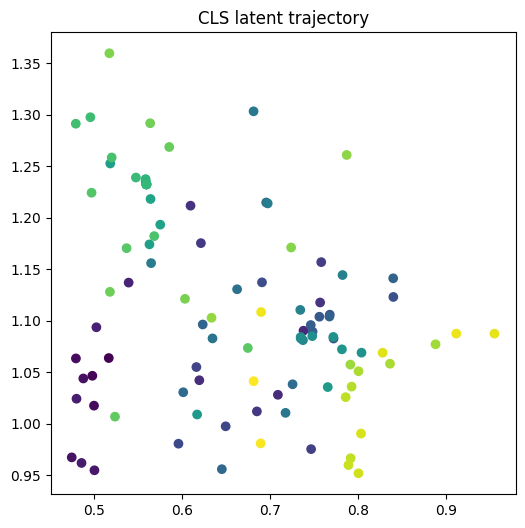

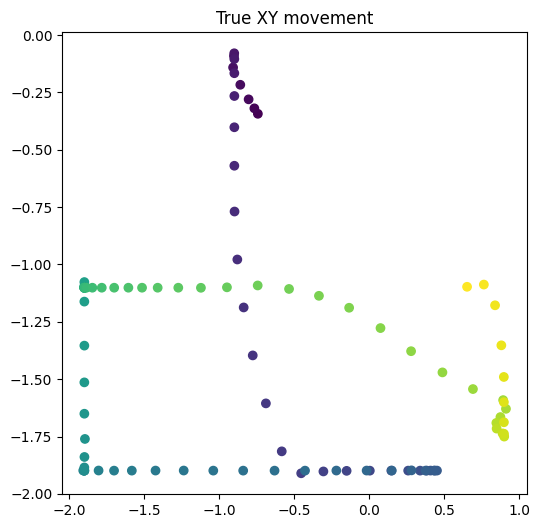

In [10]:
trajectory = list(range(100))
scatter_trajectory(trajectory)

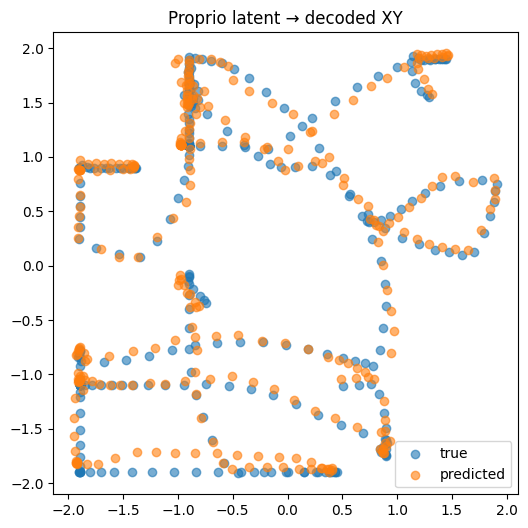

In [11]:
def evaluate_proprio_probe(n_samples=300):
    pred_xy = []
    true_xy = []

    for i in range(n_samples):
        (img,_), obs, _ = dataset[i]
        img = img.unsqueeze(0).to(device)
        pos = obs

        with torch.no_grad():
            with torch.amp.autocast("cuda", dtype=torch.bfloat16):
                # compute proprio latent token exactly like training
                latent = visual_encoder.proprio_encoder(torch.tensor(pos, dtype=torch.float32).unsqueeze(0).to(device))
                xy_pred = visual_encoder.proprio_decoder(latent)[:, :2]
                latent = latent.float()
                xy_pred = xy_pred.float()

        pred_xy.append(xy_pred.cpu().numpy()[0])
        true_xy.append(pos)

    pred_xy = np.array(pred_xy)
    true_xy = np.array(true_xy)

    plt.figure(figsize=(6,6))
    plt.scatter(true_xy[:,0], true_xy[:,1], label="true", alpha=.6)
    plt.scatter(pred_xy[:,0], pred_xy[:,1], label="predicted", alpha=.6)
    plt.legend()
    plt.title("Proprio latent → decoded XY")
    plt.show()

evaluate_proprio_probe()


In [10]:
# def show_attention(idx):
#     (img,_), obs, _ = dataset[idx]
#     img = img.unsqueeze(0).to(device)

#     with torch.no_grad():
#         cls, patches, grid_hw = visual_encoder.visual_encoder(img)
#         logits = visual_encoder.loc_head(patches)  # (B, N)

#     # Softmax to get attention heatmap
#     logits = torch.softmax(logits, dim=-1)
#     heatmap = logits[0].reshape(grid_hw).cpu().numpy()
#     img_np = img[0].permute(1,2,0).cpu().numpy()

#     fig, ax = plt.subplots(1,2, figsize=(10,4))
#     ax[0].imshow(img_np); ax[0].set_title("Image"); ax[0].axis("off")

#     # Force color scale to [0,1]
#     im = ax[1].imshow(heatmap, cmap="plasma", interpolation="nearest", vmin=0.0, vmax=1.0)
#     ax[1].set_title("Patch location prediction"); ax[1].axis("off")

#     # lateral colorbar indicating value and color (0..1)
#     cbar = fig.colorbar(im, ax=ax[1], fraction=0.046, pad=0.04)
#     cbar.set_label("saliency")
#     cbar.set_ticks([0.0, 0.5, 1.0])

#     plt.show()

In [11]:
# show_attention(20)

In [12]:
# def make_attention_video(start_idx, end_idx, output_path="attention.mp4", fps=6):
#     frames = []

#     for idx in range(start_idx, end_idx + 1):
#         (img,_), obs, _ = dataset[idx]
#         img = img.unsqueeze(0).to(device)

#         with torch.no_grad():
#             cls, patches, grid_hw = visual_encoder.visual_encoder(img)
#             logits = visual_encoder.loc_head(patches)

#         logits = torch.softmax(logits, dim=-1)
#         heatmap = logits[0].reshape(grid_hw).cpu().numpy()
#         img_np = img[0].permute(1,2,0).cpu().numpy()

#         fig, ax = plt.subplots(1, 2, figsize=(8, 4), dpi=120)

#         ax[0].imshow(img_np)
#         ax[0].set_title(f"Frame {idx}")
#         ax[0].axis("off")

#         im = ax[1].imshow(heatmap, cmap="plasma", interpolation="nearest", vmin=0.0, vmax=1.0)
#         ax[1].set_title("Patch saliency")
#         ax[1].axis("off")

#         cbar = fig.colorbar(im, ax=ax[1], fraction=0.046, pad=0.04)
#         cbar.set_label("saliency")
#         cbar.set_ticks([0.0, 0.5, 1.0])

#         # Draw and extract RGB buffer
#         fig.canvas.draw()
#         rgba = np.asarray(fig.canvas.buffer_rgba())
#         rgb = rgba[..., :3].copy()  # remove alpha channel

#         frames.append(rgb)
#         plt.close(fig)

#     imageio.mimsave(output_path, frames, fps=fps)
#     print(f"✅ Video saved to: {output_path}")

In [13]:
# make_attention_video(0, 75, output_path="attn_0_75.mp4")
# Video("attn_0_75.mp4", embed=True)

Trajectory GIF visualization

In [14]:
import imageio
from tqdm import tqdm

def generate_reconstruction_gif(traj_indices, save_path="trajectory_reconstruction.gif"):
    """
    Generate a GIF: true frame vs reconstructed frame (decoder probe only)

    Args:
        traj_indices: list of dataset indices composing a trajectory
        save_path: output filepath (gif)
    """
    frames = []  # list of numpy frames that go into the GIF

    for idx in tqdm(traj_indices, desc="Generating GIF"):
        (img,_), obs, _ = dataset[idx]
        img = img.unsqueeze(0).to(device)

        with torch.no_grad():
            cls, patches, grid_hw = visual_encoder.visual_encoder(img)
            recon = visual_encoder.visual_decoder(patches)  # STOPGRAD already in decoder

        # prepare side-by-side image (true | recon)
        original = img[0].permute(1, 2, 0).cpu().numpy()
        reconstructed = recon[0].permute(1, 2, 0).cpu().numpy()

        side_by_side = np.hstack([original, reconstructed])
        side_by_side = (side_by_side * 255).astype(np.uint8)  # convert to uint8

        frames.append(side_by_side)

    # write GIF
    imageio.mimsave(save_path, frames, fps=10)
    print(f"✅ GIF saved at: {save_path}")

# generate GIF for first trajectory of 100 frames
trajectory = list(range(100))
generate_reconstruction_gif(trajectory, "true_vs_decoded.gif")


Generating GIF: 100%|██████████| 100/100 [00:00<00:00, 860.98it/s]


✅ GIF saved at: true_vs_decoded.gif


In [15]:
import umap
from matplotlib.cm import get_cmap

def generate_umap_gif(traj_indices, save_path="umap_trajectory.gif"):
    """
    Generates a UMAP animation of CLS embeddings along a trajectory.

    Args:
        traj_indices: list of dataset indices (trajectory)
        save_path: where to save the gif
    """

    # -----------------------
    # 1) Collect embeddings
    # -----------------------
    embeddings = []
    xy_positions = []  # for coloring

    for idx in tqdm(traj_indices, desc="Encoding trajectory"):
        (img,_), obs, _ = dataset[idx]
        img = img.unsqueeze(0).to(device)        # (1,C,H,W)

        with torch.no_grad():
            cls, _, _ = visual_encoder.visual_encoder(img)

        embeddings.append(cls.squeeze().cpu().numpy())
        xy_positions.append(obs[:2])             # used for coloring optional

    embeddings = np.stack(embeddings, axis=0)     # (T, D)

    # -----------------------
    # 2) Compute UMAP on trajectory
    # -----------------------
    reducer = umap.UMAP(n_neighbors=30, min_dist=0.1, metric="cosine")
    umap_2d = reducer.fit_transform(embeddings)   # (T, 2)

    # Normalize positions 0-1 for coloring
    colors = np.linspace(0, 1, len(umap_2d))
    cmap = get_cmap("viridis")

    # -----------------------
    # 3) Build GIF frames
    # -----------------------
    frames = []
    for t in tqdm(range(len(umap_2d)), desc="Rendering GIF"):
        fig = plt.figure(figsize=(5,5))
        plt.scatter(umap_2d[:t+1, 0], umap_2d[:t+1, 1], c=colors[:t+1], cmap="viridis", s=30)
        plt.scatter(umap_2d[t, 0], umap_2d[t, 1], color="red", s=80)  # highlight current step
        plt.title(f"UMAP trajectory — frame {t+1}/{len(umap_2d)}")
        plt.axis("off")

        fig.canvas.draw()
        frame = np.array(fig.canvas.renderer.buffer_rgba())
        frames.append(frame)
        plt.close(fig)

    # -----------------------
    # 4) Save GIF
    # -----------------------
    imageio.mimsave(save_path, frames, fps=2)
    print(f"✅ UMAP GIF saved to: {save_path}")


In [16]:
trajectory = list(range(100))  # first 120 frames
generate_umap_gif(trajectory, "latent_space_umap.gif")

Encoding trajectory: 100%|██████████| 100/100 [00:00<00:00, 1075.68it/s]
/tmp/ipykernel_73633/3936924722.py:39: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap("viridis")
Rendering GIF: 100%|██████████| 100/100 [00:01<00:00, 82.35it/s]


✅ UMAP GIF saved to: latent_space_umap.gif
